# Validation of SIS model (Numerical vs Analytical)

In [1]:
import numpy as np
from ler.lens_galaxy_population import OpticalDepth
import matplotlib.pyplot as plt
%matplotlib inline 

from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [2]:
od = OpticalDepth(
    z_min=0.001, z_max=40,
    functions=dict(
        optical_depth="optical_depth_SIS_hemanta",
    ),
    sampler_priors=dict(
        velocity_dispersion="velocity_dispersion_gengamma",
        axis_ratio="axis_ratio_rayleigh",
    ),
    sampler_priors_params=dict(
        velocity_dispersion=dict(vd_min=0., vd_max=600),
        axis_ratio=dict(q_min=0.2, q_max=1),
    ),
    cosmology=cosmo,
    directory="./interpolator_pickle",
    create_new_interpolator=dict(
        velocity_dispersion=dict(create_new=True, resolution=100), 
        optical_depth=dict(create_new=True, resolution=100), 
        z_to_Dc=dict(create_new=True, resolution=100), 
        Dc_to_z=dict(create_new=True, resolution=100),
        angular_diameter_distance=dict(create_new=True, resolution=100),
        differential_comoving_volume=dict(create_new=True, resolution=100),
        )
    )

z_to_Dc interpolator will be generated at ./interpolator_pickle/z_to_Dc/z_to_Dc_2.pickle
Dc_to_z interpolator will be generated at ./interpolator_pickle/Dc_to_z/Dc_to_z_2.pickle
angular_diameter_distance interpolator will be generated at ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_2.pickle
differential_comoving_volume interpolator will be generated at ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_gengamma interpolator will be generated at ./interpolator_pickle/velocity_dispersion_gengamma/velocity_dispersion_gengamma_1.pickle
optical_depth_SIS_hemanta interpolator will be generated at ./interpolator_pickle/optical_depth_SIS_hemanta/optical_depth_SIS_hemanta_3.pickle


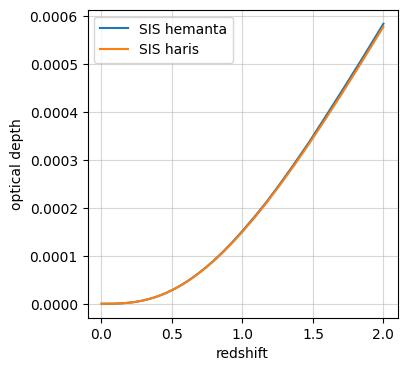

In [3]:
zs = np.geomspace(0.001, 2, 100)
tau_sis = od.strong_lensing_optical_depth(zs)
tau_sis_haris = od.optical_depth_SIS_haris(zs)

# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis, label='SIS hemanta')
plt.plot(zs, tau_sis_haris, label='SIS haris')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.legend()
plt.grid(alpha=0.5)
plt.show()


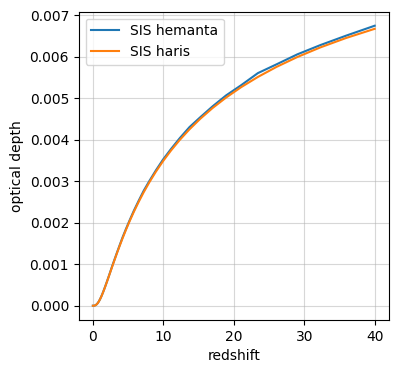

In [4]:
zs = np.geomspace(0.001, 40, 100)
tau_sis = od.strong_lensing_optical_depth(zs)
tau_sis_haris = od.optical_depth_SIS_haris(zs)

# plot 
plt.figure(figsize=(4,4))
plt.plot(zs, tau_sis, label='SIS hemanta')
plt.plot(zs, tau_sis_haris, label='SIS haris')
plt.xlabel('redshift')
plt.ylabel('optical depth')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

* close enough